<b><font size="+3">Training a machine learning model to judge you and I shallowly based on looks</font></b>

This notebook will document the analysis and the training of a machine learning model on a human faces dataset that I fetched from Reddit.

The model will aim to decide, amongst other things, the attractiveness of the subject displayed in an image. /r/rateme has just the right data for this, with the subject's age, gender and most importantly their 'attractiveness', as judged by real people documented in each thread.

<b><font size="+2">Setting up</font></b>

In [107]:
# importing the relevant libraries
# visualisation
import matplotlib.pyplot as plt
%matplotlib inline

# models and data processing
import sklearn.linear_model as models
import sklearn.neural_network as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# reading CSV 
import numpy as np
from pandas import read_csv
from pandas import DataFrame
# we get some errors when plotting the graph, supressing these for now
_ = np.seterr(invalid='ignore')

At this point, we have already:
- gathered the data (rating, age + picture) from reddit, /r/rateme subreddit
    - the data is gathered using regular expressions on the comments section and the title.
    - for the rating, we simply took an average of all the ratings in the comments
    - the age of the subject is present for most posts in the post title
- encoded the faces using VGG-face to obtain a feature vector for each face
- formed .csv files, for male and female faces, where each row corresponds to a datapoint. 
    - The first 4096 entries are the features from VGG
    - the second to last column are the face's rating
    - the last column is the face's age

In [108]:
# location of data stored
data_root = './data/vgg_encoded/'
male_csv = data_root + 'male.csv'
female_csv = data_root + 'female.csv'

Interestingly, there are much more males than females who wanted to get their faces rated on /r/rateme! For this reason, we will first try out the female part of our dataset (we have ~12,500 female entries, and ~37,500 male entries)

This could potentially be due to a combination of:
- males not receiving as much feedback on their appearance during their day-to-day life compared to females
- there simply being more males than females on reddit, or on /r/rateme

So now all that's left is to train the regressor on the face's ratings!

In [109]:
# reading in the CSV file as an numpy array
# the 1: is due to my stupidity - I've accidentally also saved the index into the first column of the .csv
# and finally dropna() is to deal with the NaN's we have in the dataset
female_data = read_csv(female_csv, nrows=5000).dropna().values[:, 1:]

X_female, targets_female = female_data[:, :-2], female_data[:, -2:]
rating_female, age_female = targets_female[:, 0], targets_female[:, 1]

# perform a train/test/validation split. 80% used for training, 20% for testing and 10% for validating
X_female_train, X_female_test, targets_female_train, targets_female_test = train_test_split(
    X_female, targets_female, test_size=0.2)

rating_female_train, rating_female_test = targets_female_train[:, 0], targets_female_test[:, 0]
age_female_train, age_female_test = targets_female_train[:, 1], targets_female_test[:, 1]

<b><font size="+2">Visualisation</font></b>

Before we start, let's take a look at what our data looks like.

Let's first note down some summary statistics:

In [110]:
# summary statistics
rating_age_female_data = {'rating': rating_female, 'age': age_female}
rating_age_female_df = DataFrame(data=rating_age_female_data)
rating_age_female_df.describe()

,age,rating
count,4947.000000,4947.000000
mean,21.150596,6.835679
std,3.850176,1.044844
min,1.000000,1.500000
25%,19.000000,6.342857
50%,20.000000,6.987500
75%,23.000000,7.533333
max,91.000000,10.000000


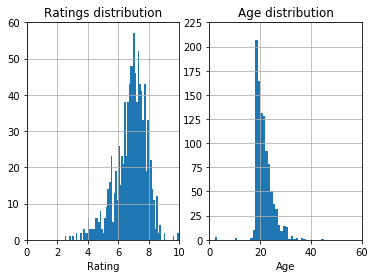

In [111]:
# histogram for ratings
plt.subplot(121)
plt.hist(rating_female[:1000], bins=100, range=(0,10))
plt.title('Ratings distribution'); plt.xlabel('Rating'); plt.axis([0,10,0,60])
plt.grid(True)

# histogram for age
plt.subplot(122)
plt.hist(age_female[:1000], bins=60, range=(0,60))
plt.title('Age distribution'); plt.xlabel('Age'); plt.axis([0,60,0,225])
plt.grid(True)

plt.show(); plt.clf()

From these plots we can see that ratings distributions follows a normal / log normal distribution with a mean of around 7 (!), whilst the age distribution resembles quite closely a gamma distrubtion. 

(!): Perhaps guys just find all girls beautiful after all, or perhaps people are a little too kind on /r/rateme! As a result, should we normalise our output to a mean of 5, so that it resembles more closely the 'ideal' attractiveness scale? <font size="-2">I think there is no need. As a man I fall in love with every other women I see on the streets, so an average of 7 is not surprising at all. ;)</font>

Let's also take a look at the features:

In [117]:
# pick 10 sample features randomly, from the interval [0, 4095]
sample_points = np.trunc(np.random.random_sample(10) * 4096).astype(int)
feature_sample = X_female[:, sample_points]

# and print out the statistics of the sampled features.
print(DataFrame(data=feature_sample, columns=sample_points).describe())

              3605         3714         3217         1175         1776  \
count  4947.000000  4947.000000  4947.000000  4947.000000  4947.000000   
mean    438.754806   376.107414    16.496911   378.893609    92.268153   
std     987.374051   892.558408   198.595037   804.443528   500.831724   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%     273.170593    54.423771     0.000000   261.565796     0.000000   
max    6515.465332  7044.307129  4130.792480  4870.989258  6928.984863   

               2543         2600         883          3799         1136  
count   4947.000000  4947.000000  4947.000000  4947.000000  4947.000000  
mean    1079.772845   286.453134    60.875654   214.482176   529.755912  
std     1632.865988   783.609150   331.525520   676.276204  1243.445538  
min        0.000000     0.000000     

Looks like the features are quite sparse. In order to take a closer look we need to filter out the places where the feature is non-present. 

In [115]:
# taking a closer look at the first of the sampled features
feature_0 = feature_sample[:, 0]
feature_0_nonzero = feature_0[feature_0 != 0]

# and print out its descriptive statistics
print(DataFrame(feature_0_nonzero).describe())

                 0
count    40.000000
mean    868.157739
std     591.781926
min     131.401611
25%     374.674622
50%     723.051788
75%    1332.239990
max    2125.386719
[  919.24511719   919.24511719   919.24511719   919.24511719   632.45251465
   632.45251465   632.45251465   632.45251465   374.67462158   374.67462158
   374.67462158   374.67462158   813.65106201   813.65106201   813.65106201
   813.65106201  1478.72644043   322.27911377  1478.72644043   322.27911377
  1478.72644043   322.27911377  1478.72644043   322.27911377   551.52020264
   551.52020264   551.52020264   551.52020264  2125.38671875  2125.38671875
  2125.38671875  2125.38671875   131.40161133   131.40161133   131.40161133
   131.40161133  1332.23999023  1332.23999023  1332.23999023  1332.23999023]


Anyways, with all that being said, let's train our regressors for now and see what kind of results we get.

<b><font size="+2">Preprocessing</font></b>

Before we fit our model, we first standardise our features to help our model converge. To do this, we will make use of scikit learn's tools, which will standardise our features for us. We will also make use a pipeline so to streamline the work that goes on before our data goes through our model in the future (i.e. testing phase and beyond)

Standardisation in fact becomes not-even-a-one-liner with sklearn, (thanks to the StandardScaler class). So let's move onto the next step, which is choosing a regression model.

<b><font size="+2">Regression</font></b>

There are a few models which will potentially do the job. Models such as Linear Regression (we will use a variant such as Lasso), Bayesian Regression or a neural network could all potentially work. We will try to evaluate a few of these on our data.

First up is Lasso regression. Scikit learn surprised me once again with automatic cross-validation. And luckily enough, Lasso has a corresponding CV class, LassoCV which will automatically do cross-validation for us.

In [153]:
# Lasso model with standardisation.
# ``alphas`` is for cross-validation: the range of regularization penalty we want to try
alphas = np.linspace(0, 1e-1, num=100)
lasso = make_pipeline(StandardScaler(), models.LassoCV(alphas=alphas, n_jobs=-1))
# fit lasso regression
lasso.fit(X_female_train, rating_female_train)
print('alpha chosen:', lasso.steps[1][1].alpha_)

/home/pingshiyu/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pingshiyu/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


alpha chosen: 0.0616161616162


This resulted in choosing alpha=0.05 as our penalty. Let's take a look at the results given by this value. We define an evaluation function whilst we're at it so that we can evaluate other models quickly also.

In [149]:
def mse(y, y_):
    '''
    Returns the mean squared error between ``y`` and ``y_``
    y, y_: numpy arrays of the same dimension
    '''
    return np.mean((y - y_)**2)

def evaluate_model(model, Xval=X_female_validate, yval=rating_female_validate):
    '''
    Given a model, output evaluation information about the model's performance on the validation set.
    '''
    # evaluate the model
    val_prediction = model.predict(Xval)
    print('MSE on test set:', mse(val_prediction, yval))
    print('R^2 score:', model.score(Xval, yval))
    print('predictions statistics:')
    print(DataFrame({'prediction': model.predict(Xval)}).describe())

We also visualise with a scatterplot, where we can see how the prediction relates to the actual values. If the model were perfect, then that means all of the predictions and the actual values are equal - thus all of the points of the plot will be along the line $y = x$. The further the plot deviates from that line, the less 'similar' our predictor is to the correct values.

In [168]:
def model_scatterplot(model, Xval=X_female_validate, yval=rating_female_validate):
    '''
    Visualize the model with a scatter-plot. This will show us how 'correlated' the model predictions and the actual 
    test set are. 
    
    A perfectly correlated dataset should look like the graph y = x, where it is just a straight diagonal line.
    '''
    # plotting the graph of the predictions
    pred = model.predict(Xval)
    plt.plot(yval, model.predict(Xval), 'ro', markersize=0.5)
    plt.xlabel('actual'); plt.ylabel('predicted');
    plt.xlim((0,10)); plt.ylim((0,10))
    plt.show(); plt.clf()

In [165]:
# print the results
evaluate_model(lasso)

MSE on test set: 1.05185258321
R^2 score: 0.00644534466636
predictions statistics:
       prediction
count  495.000000
mean     6.844835
std      0.031591
min      6.749209
25%      6.835365
50%      6.843956
75%      6.853484
max      6.938419


Unfortunately, this value of alpha resulted in an R^2 score very close to zero. Implying the model is severely underfitting - in fact it is just predicting the average of the dataset for all points!

The model is in very bad health, and some treatment is needed immediately. 

<font size="+1">Diagnosing the illness of linear regression</font>

First thing we need to find out is how the model varies according to `alpha`, our regularization parameter. The value of `alpha` corresponds to the 'complexity' of the model, the lower the value of `alpha`, the more 'complex' it is. A more complex model is more likely to overfit, and a less complex model is more likely to underfit. 

Thus, when
- `alpha` is small: $\implies$ the model is more complex $\implies$ the model may overfit $\implies$ lower training error; higher testing error
- `alpha` is big: $\implies$ the model is less complex $\implies$ the model may underfit $\implies$ higher training error; similarly high validation error

So, if we plot the training and testing errors on a graph, against the value of `alpha` we choose for our model, we may expect for the training error curve to:
- be high for small `alpha`, and dropping as `alpha` gets larger

in the meanwhile, the validation error curve may:
- be high for small `alpha`, and also high for large `alpha`. 

So between those two curves, there should exist a sweet spot for a choice of `alpha` where the MSE for the validation set is not too high, and for the training set not too close to zero. This `alpha` should be close to where the model is neither overfitting nor underfitting.

Let's plot the graph and see what it looks like in theory.

In [11]:
def plot_mse_graph(Model, X, y, Xval, yval, alpha_range=(0,0.1), points=100):
    '''
    Plots the graph of alpha against the MSE of the ``Model`` on the training and validation sets.
    '''
    training_MSE, validation_MSE = [], []
    # loop over the range of alphas
    alphas = np.linspace(*alpha_range, num=points)
    for alpha in alphas:
        # create and fit the model on training set
        model = make_pipeline(StandardScaler(), Model(alpha))
        model.fit(X, y)
        
        # evaluate the MSE on training and validation set
        training_MSE.append(mse(y, model.predict(X)))
        validation_MSE.append(mse(yval, model.predict(Xval)))
        
    # plot the data
    training_line = plt.plot(alphas, training_MSE, label='training')
    validation_line = plt.plot(alphas, validation_MSE, label='validation')
    plt.xlabel('alpha'); plt.ylabel('MSE'); plt.legend()
    plt.grid(True)
    plt.show(); plt.clf()

/home/pingshiyu/.local/lib/python3.6/site-packages/sklearn/pipeline.py:250: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/home/pingshiyu/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/pingshiyu/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


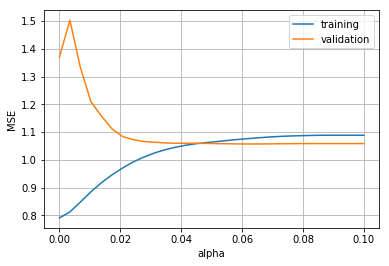

In [12]:
# plotting the complexity vs. MSE graph
plot_mse_graph(models.Lasso, 
               X_female_train, rating_female_train, 
               X_female_validate, rating_female_validate,
               points=30)

Unfortunately, from this graph, it can be seen that there is not really a 'sweet spot' where the model is neither underfitting nor overfitting. In fact, the validation error never dips below ~1.1, meaning that the model might as well be guessing the mean for everything at that point, seeing as the standard deviation is only ~1.04.

<b> Diagnosis: A linear model is not complex enough to model our attractiveness function. </b>

<b><font size="+2">Bayesian Regression</font></b>

Next we will give Bayesian Regression a shot. This model is preset in the `sklearn` library. We will quickly give it a run to see if the results are promising.

In [170]:
# initialize and fit the bayesian (ridge) regression model
bayes = make_pipeline(StandardScaler(), models.BayesianRidge())
bayes.fit(X_female_train, rating_female_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('bayesianridge', BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False))])

In [171]:
# evaluate the model
evaluate_model(bayes)

MSE on test set: 1.00154088627
R^2 score: 0.053968563711
predictions statistics:
       prediction
count  495.000000
mean     6.839415
std      0.099913
min      6.560430
25%      6.770886
50%      6.852413
75%      6.900741
max      7.207414


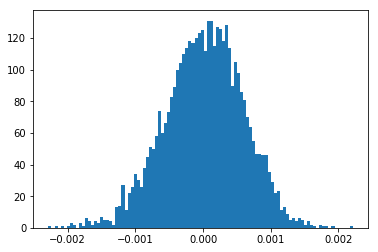

In [172]:
# seeing the distribution of the weights
bayes_model = bayes.steps[1][1]
plt.hist(bayes_model.coef_, bins=100)
plt.show(); plt.clf()

Unfortunately, Bayesian Ridge Regression, still being a linear model, does not fare much better than other forms of linear regression. We therefore now move on to some non-linear models in search for a slither of hope.

<b><font size="+2">Neural Network Model</font></b>

As the model seemed a little too complicated for a linear model, it would seem natural to try something more complicated, for example a neural network. Scikit-learn once again has a preset neural network model in their library, and we will be using that interface here also.

We will be using an adaptive learning rate, where it begins at a certain value, i.e. $10^{-2}$ and is decreased if the loss is not improved for two consecutive epochs.

In [18]:
# defining and fitting the network
network = make_pipeline(StandardScaler(), 
                        nn.MLPRegressor(hidden_layer_sizes=(100,), solver='adam',
                                        learning_rate='adaptive', learning_rate_init=1e-4,
                                        verbose=True))
network.fit(X_female_train, rating_female_train)

Iteration 1, loss = 22.73228996
Iteration 2, loss = 8.06588417
Iteration 3, loss = 2.22711841
Iteration 4, loss = 0.72231897
Iteration 5, loss = 0.52016163
Iteration 6, loss = 0.47809452
Iteration 7, loss = 0.45932005
Iteration 8, loss = 0.44797987
Iteration 9, loss = 0.44614957
Iteration 10, loss = 0.44211884
Iteration 11, loss = 0.44558094
Iteration 12, loss = 0.44496895
Iteration 13, loss = 0.44964050
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlpregressor', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(500,), learning_rate='adaptive',
   ...e=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False))])

MSE on test set: 6.75482511919
R^2 score: -5.38044536873
predictions statistics:
       prediction
count  495.000000
mean     5.019721
std      1.471048
min      0.342644
25%      4.330471
50%      5.199806
75%      5.986735
max      8.070972


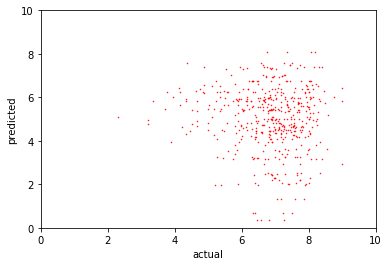

In [147]:
# evaluate the model
evaluate_model(network)
model_scatterplot(network)

<b><font size="+2">Boosting Models</font></b>

We will also try a range of boosting models to see how it performs.

<font size="+1">Gradient Boosting</font>

In [130]:
import sklearn.ensemble as ensemble

# use the gradient-boosting model
gradient_boost = ensemble.GradientBoostingRegressor()
gradient_boost.fit(X_female_train, rating_female_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

MSE on test set: 0.916290865989
R^2 score: 0.13449368279
predictions statistics:
       prediction
count  495.000000
mean     6.833395
std      0.289777
min      4.763406
25%      6.711130
50%      6.876876
75%      6.975204
max      7.491669


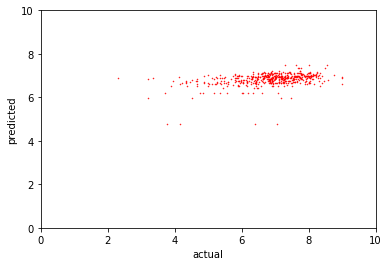

In [148]:
# evaluate the model
evaluate_model(gradient_boost)
model_scatterplot(gradient_boost)

<font size="+1">AdaBoost</font>

In [163]:
# use the model
adaboost = ensemble.AdaBoostRegressor(loss='exponential')
adaboost.fit(X_female_train, rating_female_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='exponential',
         n_estimators=50, random_state=None)

MSE on test set: 1.18138645753
R^2 score: -0.115909238002
predictions statistics:
       prediction
count  495.000000
mean     6.441180
std      0.173907
min      5.811374
25%      6.387219
50%      6.431135
75%      6.518637
max      6.811116


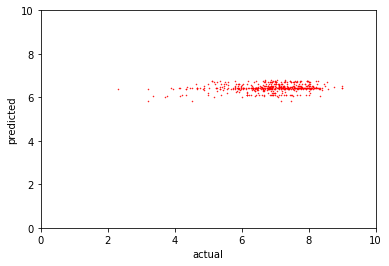

In [164]:
# evaluate the model
evaluate_model(adaboost)
model_scatterplot(adaboost)

<b><font size="+2">Random Forest Regressor</font></b>

In [157]:
# use the RF model
random_forest = ensemble.RandomForestRegressor()
random_forest.fit(X_female_train, rating_female_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

MSE on test set: 0.926168679691
R^2 score: 0.125163337508
predictions statistics:
       prediction
count  495.000000
mean     6.841979
std      0.600853
min      4.240165
25%      6.558279
50%      6.928008
75%      7.245124
max      8.010604


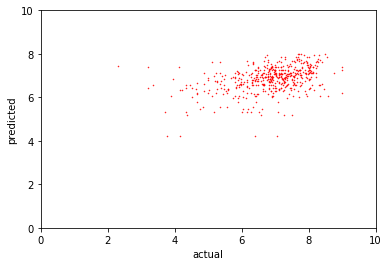

In [158]:
# evaluate the model
evaluate_model(random_forest)
model_scatterplot(random_forest)

<b><font size="+2">Support Vector Machine</font></b>

<font size="+1">NuSVR</font>

In [140]:
import sklearn.svm as svm

# use the NuSVR model
nusvm = svm.NuSVR()
nusvm.fit(X_female_train, rating_female_train)

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

MSE on test set: 0.894771831454
R^2 score: 0.154820045327
predictions statistics:
       prediction
count  495.000000
mean     6.866178
std      0.460895
min      4.888150
25%      6.750327
50%      6.888150
75%      7.112331
max      7.888150


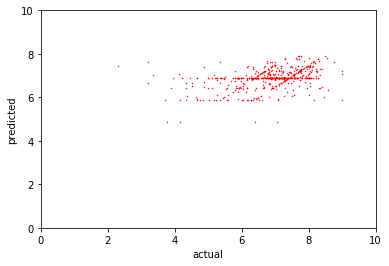

In [150]:
# evaluate the model
evaluate_model(nusvm)
model_scatterplot(nusvm)

<font size="+1">SVR</font>

In [142]:
# use the SVR model
svm = svm.SVR()
svm.fit(X_female_train, rating_female_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

MSE on test set: 0.942472866617
R^2 score: 0.109762794617
predictions statistics:
       prediction
count  495.000000
mean     6.931668
std      0.489781
min      4.929921
25%      6.839680
50%      6.929921
75%      7.138958
max      7.929921


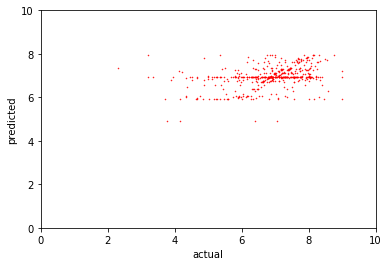

In [155]:
# evaluate the model
evaluate_model(svm)
model_scatterplot(svm)

<font size="+2"> <b> Testing section </b> </font>

In [20]:
# import new data
from sklearn import datasets

diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [31]:
lasso = models.Lasso(fit_intercept=False)
lasso.fit(X_female_train, age_female_train)

/home/pingshiyu/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [32]:
# evaluate
evaluate_model(lasso)
print(mse(lasso.predict(X_female_train), age_female_train))

MSE on test set: 215.173795897
R^2 score: -202.247993142
predictions statistics:
       prediction
count  495.000000
mean    21.313449
std      2.100468
min     17.260653
25%     19.959664
50%     21.121862
75%     22.181591
max     29.283579
10.2591732562


In [34]:
pred = lasso.predict(X_female_test)
np.set_printoptions(suppress=True)

DataFrame({'pred': pred}).describe()

12.1279757168
20.6702245658


,diff
count,990.000000
mean,-0.245132
std,4.542133
min,-31.473606
25%,-2.594549
50%,-0.460244
75%,2.164202
max,24.750030


In [126]:
# pick some sample features randomly, from the interval [0, 4095]
sample_points = np.trunc(np.random.random_sample(4000) * 4096).astype(int)
feature_sample = X_female[:, sample_points]

In [127]:
# train classifier on a sample of features, see how that performs
feature_sample_train, feature_sample_test, rating_sample_train, rating_sample_test = train_test_split(
    feature_sample, rating_female, test_size=0.2)

lr = models.LinearRegression()
lr.fit(feature_sample_train, rating_sample_train)

lr.score(feature_sample_test, rating_sample_test)

-5.0356053700952786e+23